In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pickle

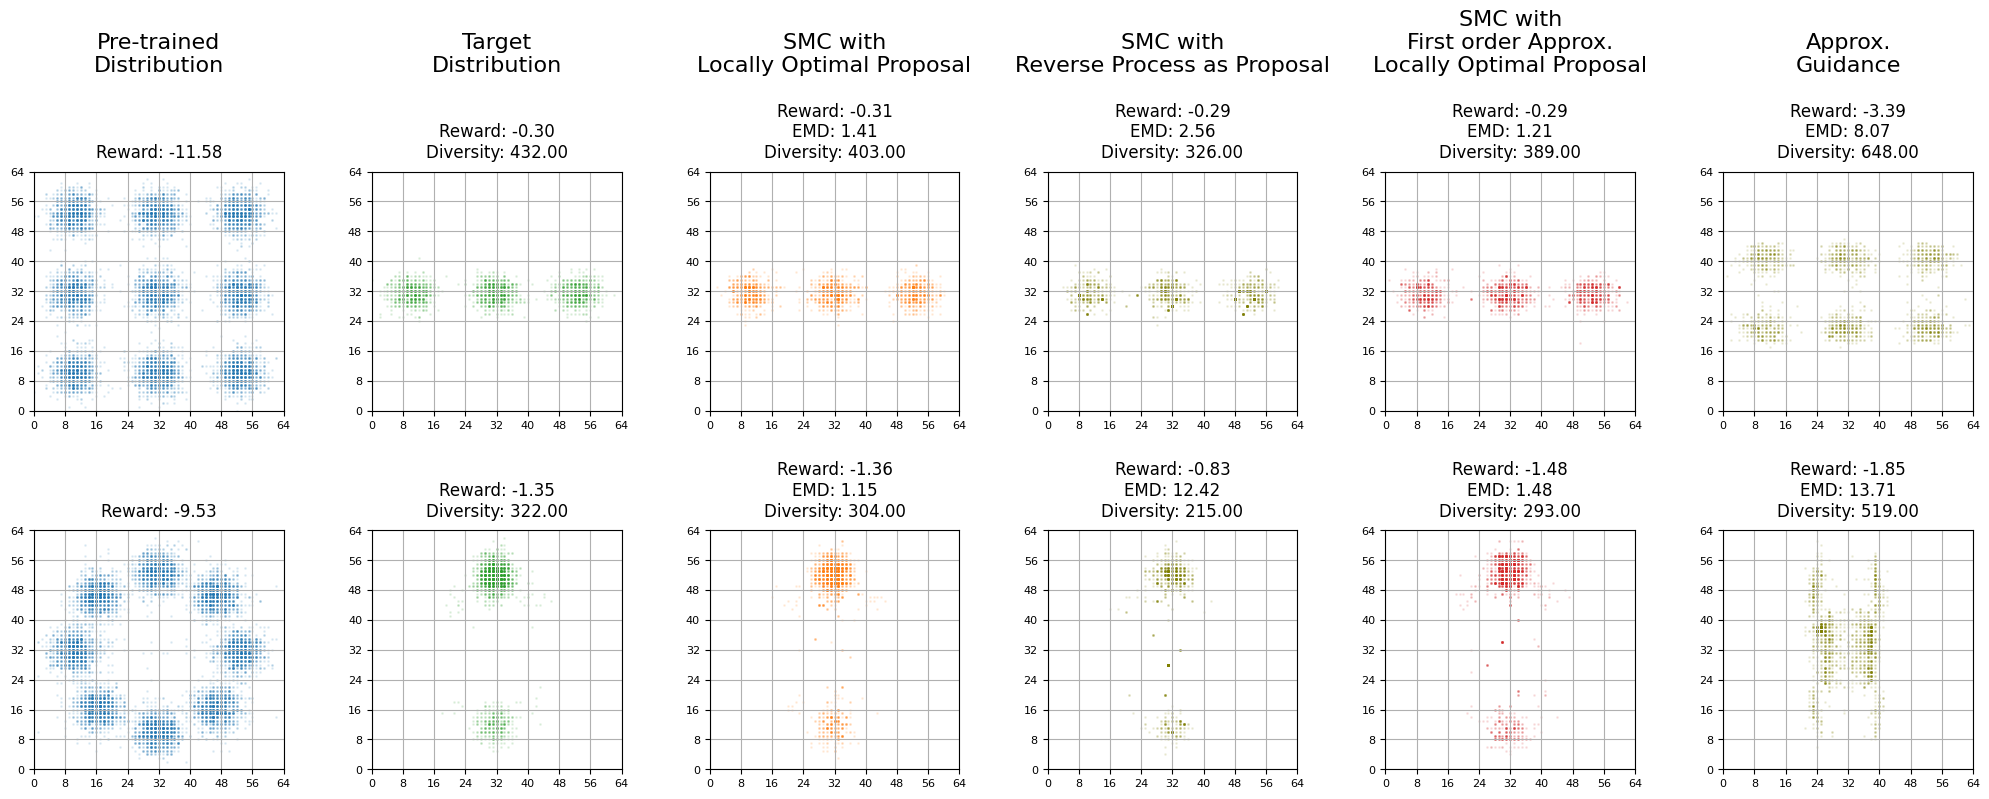

In [69]:
# 1) Load both datasets
with open("plot_data/smc_mdm_gmm1.pkl", "rb") as f:
    data1 = pickle.load(f)
with open("plot_data/smc_mdm_gmm2.pkl", "rb") as f:
    data2 = pickle.load(f)

all_data = {
    "GMM‑1": data1,
    "GMM‑2": data2,
}

# 2) Column order and colors
col_order  = ["pre_trained", "target", "locally_optimal", "reverse", "first_order", "guidance"]
col_titles = {
    "pre_trained":    "Pre‑trained\nDistribution",
    "target":         "Target\nDistribution",
    "locally_optimal":"SMC with\nLocally Optimal Proposal",
    "reverse":        "SMC with\nReverse Process as Proposal",
    "guidance":       "Approx.\nGuidance",
    "first_order":    "SMC with\nFirst order Approx.\nLocally Optimal Proposal",
}
col_colors = {
    "pre_trained":    "tab:blue",
    "target":         "tab:green",
    "locally_optimal":"tab:orange",
    "reverse":        "olive",
    "guidance":       "olive",
    "first_order":    "tab:red",
}

# 3) Plot
n_rows, n_cols = len(all_data), len(col_order)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(20, 8.3),
                         squeeze=False)

for i, (row_name, methods_dict) in enumerate(all_data.items()):
    for j, meth in enumerate(col_order):
        ax = axes[i, j]
        block = methods_dict[meth]
        X = block["samples"]
        r = block.get("reward", np.nan)
        e = block.get("emd", None)
        diversity = block.get("diversity", None)

        # scatter with your chosen color
        ax.scatter(X[:,0], X[:,1],
                   s=1, alpha=0.1,
                   color=col_colors[meth])

        ax.set_xlim(0, 64)
        ax.set_ylim(0, 64)
        ax.set_xticks([tick for tick in range(0, 65, 8)])
        ax.set_yticks([tick for tick in range(0, 65, 8)])
        ax.tick_params(axis='both', labelsize=8)
        ax.grid(True)

        
        # 1) Main title line (only top row), even higher
        if i == 0:
            ax.text(
                0.5, 1.4,                       # <-- y bumped up from 1.12 → 1.18
                col_titles[meth],
                transform=ax.transAxes,
                ha="center", va="bottom",
                fontsize=16
            )

        # 2) Subtitle with reward/EMD, pushed further down
        subtitle = f"Reward: {r:.2f}"
        if e is not None:
            subtitle += f"\nEMD: {e:.2f}"
        if diversity is not None:
            subtitle += f"\nDiversity: {diversity:.2f}"
        ax.set_title(subtitle,
                     fontsize=12,
                     pad=10)                    # <-- increased pad from 20 → 25

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # <-- increase vertical space between rows
plt.show()